# Assignment 7 
Halka Hanna


In [26]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

### Helper function

In [27]:
def build_model(train, val, holiday=False, season=False, s_name=None, p=1, calculate_metrics=True, pred_len=None, freq=None):
    model = Prophet()
    if holiday == True:
        model.add_country_holidays(country_name='US')
    if season == True:
        model.add_seasonality(name=s_name, period=p, fourier_order=20)


    if calculate_metrics == False:
        df = pd.concat([train, val], axis=0)
        model.fit(df)
        future_year = model.make_future_dataframe(periods=pred_len, freq=freq)
        forecast = model.predict(future_year)
        return model, forecast
    else:
        model.fit(train)
        future_test = val[['ds']].copy()
        forecast_test = model.predict(future_test)

        y_true = val['y'].values
        y_pred = forecast_test['yhat'].values
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

        print(f" MAE = {mae:.2f},\n RMSE = { rmse:.2f}, MAPE = {mape:.2f}")
        if holiday == True:
            model_name = 'holiday'
        if season == True:
            model_name = 'seasonal'
        else:
            model_name = 'Prophet'

        df = pd.DataFrame({'model': [f'model_{model_name}'],
                           'rmse':  [rmse],
                           'mae':   [mae],
                           'mape':  [mape],
                          }).set_index('model')

        return forecast_test['yhat'], df


In [28]:
def pred_plot(ds, y_true, y_pred, title=None):
    plt.figure(figsize=(15, 6))
    plt.plot(ds, y_true, label='True values', color='black', alpha=0.6)
    plt.plot(ds, y_pred, label='Pred values', color='red', alpha=0.6)
    plt.title(title)
    plt.legend()
    plt.show()

In [29]:
def final_model(m, forecast_year, ylabel, title): # , year='1990-12-31'):
    # year = pd.to_datetime(year)
    plt.figure(figsize=(15, 7))
    m.plot(forecast_year, ax=plt.gca())
    plt.xlabel('Date')
    plt.ylabel(ylabel)
    plt.title(title)
    m.plot_components(forecast_year)
    # ax.axvline(year, color='red', ls='--')
    plt.show()

---
## Daily Temperature

In [30]:
tempt = pd.read_csv('../data/daily_tempt.csv')
tempt['data_ind'] = tempt['Date']
tempt = tempt.set_index('data_ind')
tempt.index = pd.to_datetime(tempt.index)

train_df = tempt.loc[tempt.index < '1988-01-01']
val_df = tempt.loc[tempt.index >= '1988-01-01']

train = train_df[['mean-tempt']].reset_index()
train['unique_id'] = 'tempt'
train.rename(columns={'data_ind': 'ds', 'mean-tempt': 'y'}, inplace=True)
train_tempt = train[['unique_id', 'ds', 'y']]

val = val_df[['mean-tempt']].reset_index()
val['unique_id'] = 'tempt'
val.rename(columns={'data_ind': 'ds', 'mean-tempt': 'y'}, inplace=True)
val_tempt = val[['unique_id', 'ds', 'y']]

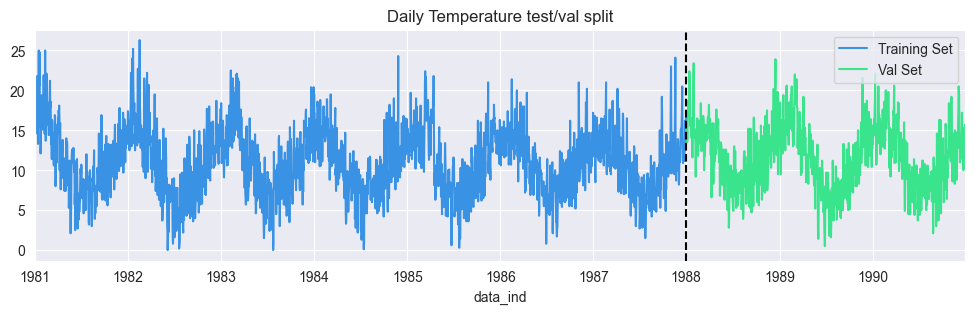

In [31]:
y_train = train_df['mean-tempt']
y_val = val_df['mean-tempt']

fig, ax = plt.subplots(figsize=(12, 3))
y_train.plot(ax=ax, label='Training Set', title='Daily Temperature test/val split', color='#3A92E4')
y_val.plot(ax=ax, label='Val Set', color='#3AE48C')
ax.axvline('1988-01-01', color='black', ls='--')
ax.legend(['Training Set', 'Val Set'])
plt.show()

17:41:15 - cmdstanpy - INFO - Chain [1] start processing
17:41:16 - cmdstanpy - INFO - Chain [1] done processing


 MAE = 2.10,
 RMSE = 2.69, MAPE = 22.70


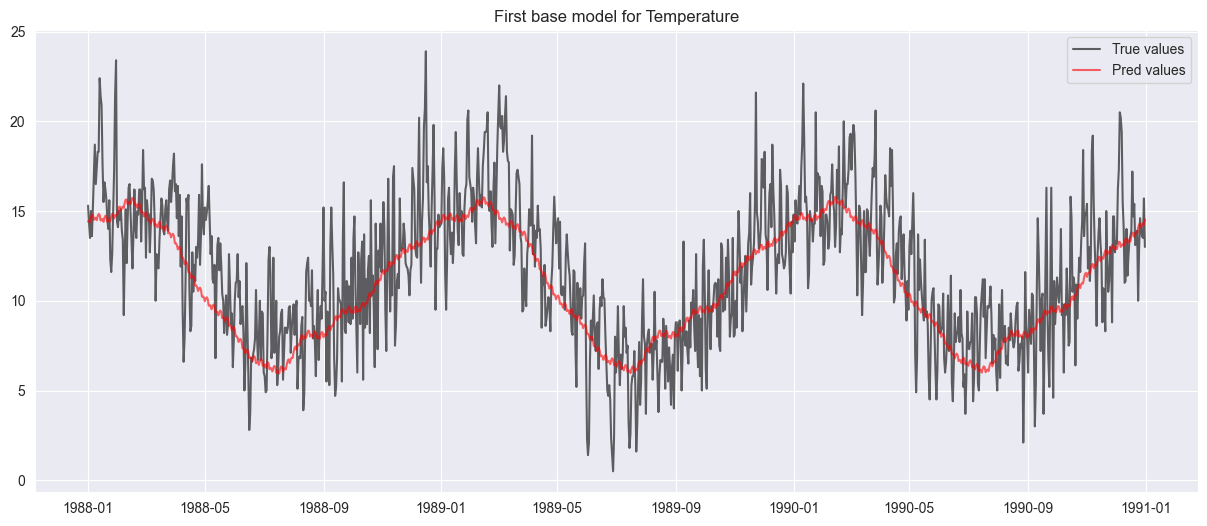

In [32]:
pred, df1 = build_model(train_tempt, val_tempt)
pred_plot(val_tempt['ds'], val_tempt['y'], pred, title="First base model for Temperature")

17:41:16 - cmdstanpy - INFO - Chain [1] start processing
17:41:16 - cmdstanpy - INFO - Chain [1] done processing


 MAE = 2.12,
 RMSE = 2.71, MAPE = 22.86


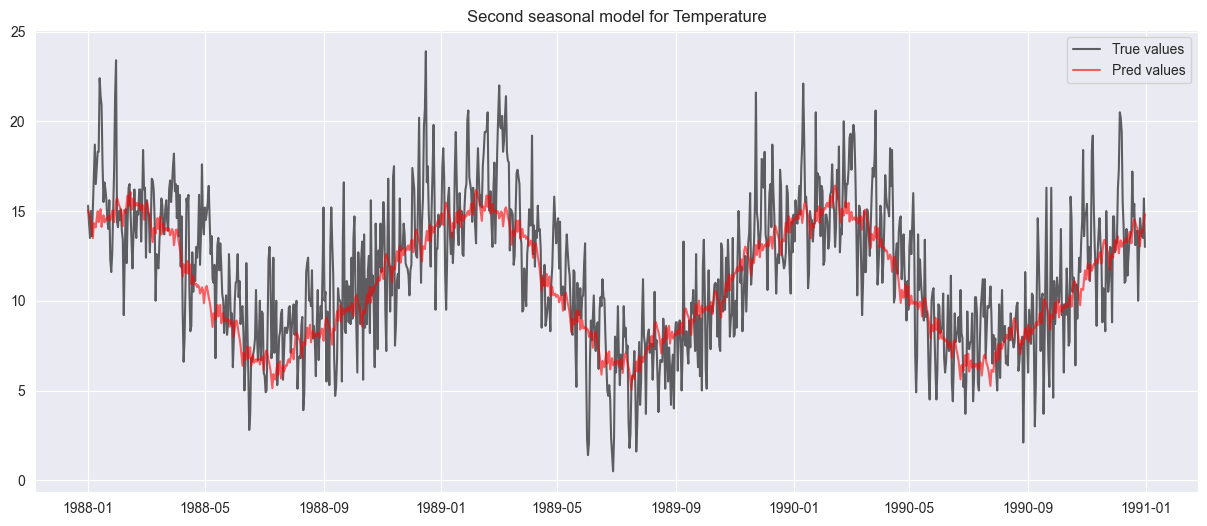

In [33]:
pred, df2 = build_model(train_tempt, val_tempt, season=True, s_name='weekly', p=31)
pred_plot(val_tempt['ds'], val_tempt['y'], pred, title="Second seasonal model for Temperature")

In [34]:
metrics = pd.read_csv('../metrics/metrics_tempt.csv', index_col='model')
metrics = pd.concat([metrics, df1, df2], axis=0)
metrics.to_csv("../metrics/metrics_tempt.csv", index=True)
metrics

,rmse,mae,mape
model,,,
Seasonal 7,1.097965,0.883646,4456.554084
Seasonal 31,0.624270,0.441416,450.474778
Seasonal 365,0.570816,0.423729,53.324711
Seasonal add 365,3.491521,2.821122,26.785994
model_Prophet,2.689473,2.100469,22.701160
model_seasonal,2.705012,2.119979,22.862539


### Results:

First model is the best.

| model     | MAE  | RMSE |
|-----------|------|------|
| Base      | 2.10 | 2.69 |
| Seasonal  | 2.13 | 2.72 |

17:41:16 - cmdstanpy - INFO - Chain [1] start processing
17:41:16 - cmdstanpy - INFO - Chain [1] done processing


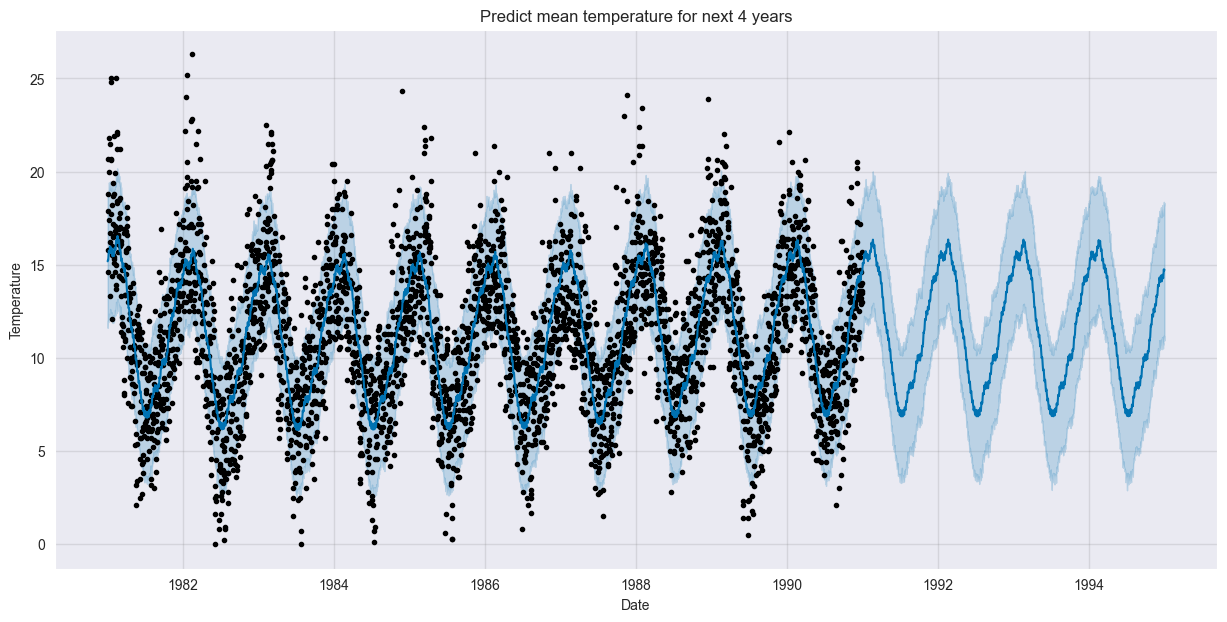

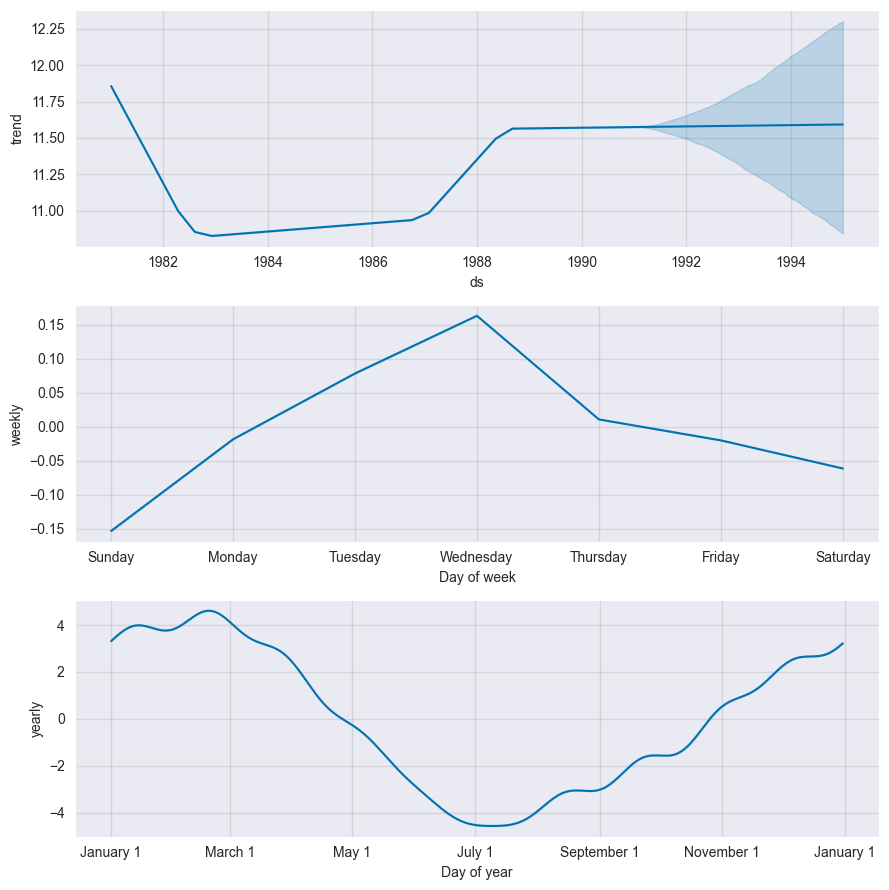

In [35]:
model, pred = build_model(train_tempt, val_tempt, calculate_metrics=False, pred_len=1461, freq='D')
final_model(model, pred, 'Temperature', title="Predict mean temperature for next 4 years")

---
## Weekly CO2


In [36]:
co2 = pd.read_csv('../data/weekly_co2.csv')
co2 = co2[['Date', 'average']]
co2['data_ind'] = co2['Date']
co2 = co2.set_index('data_ind')
co2.index = pd.to_datetime(co2.index)

train_df = co2.loc[co2.index < '2015-07-05']
val_df = co2.loc[co2.index >= '2015-07-05']

train = train_df[['average']].reset_index()
train['unique_id'] = 'co2'
train.rename(columns={'data_ind': 'ds', 'average': 'y'}, inplace=True)
train_co2 = train[['unique_id', 'ds', 'y']]

val = val_df[['average']].reset_index()
val['unique_id'] = 'co2'
val.rename(columns={'data_ind': 'ds', 'average': 'y'}, inplace=True)
val_co2 = val[['unique_id', 'ds', 'y']]

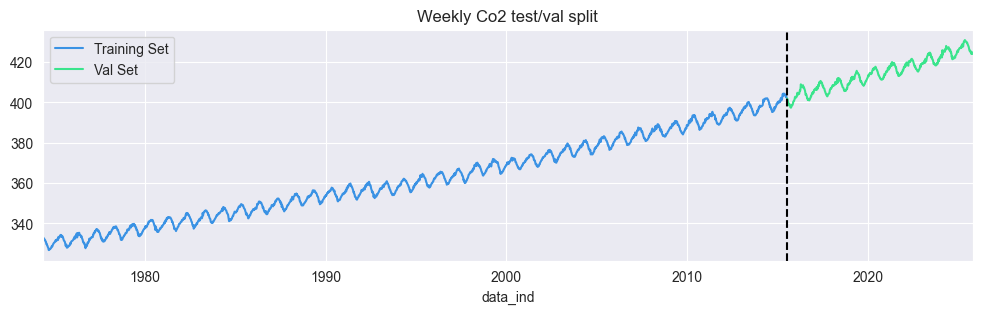

In [37]:
y_train = train_df['average']
y_val = val_df['average']

fig, ax = plt.subplots(figsize=(12, 3))
y_train.plot(ax=ax, label='Training Set', title='Weekly Co2 test/val split', color='#3A92E4')
y_val.plot(ax=ax, label='Val Set', color='#3AE48C')
ax.axvline('2015-07-05', color='black', ls='--')
ax.legend(['Training Set', 'Val Set'])
plt.show()

17:41:17 - cmdstanpy - INFO - Chain [1] start processing
17:41:17 - cmdstanpy - INFO - Chain [1] done processing


 MAE = 2.67,
 RMSE = 2.97, MAPE = 0.64


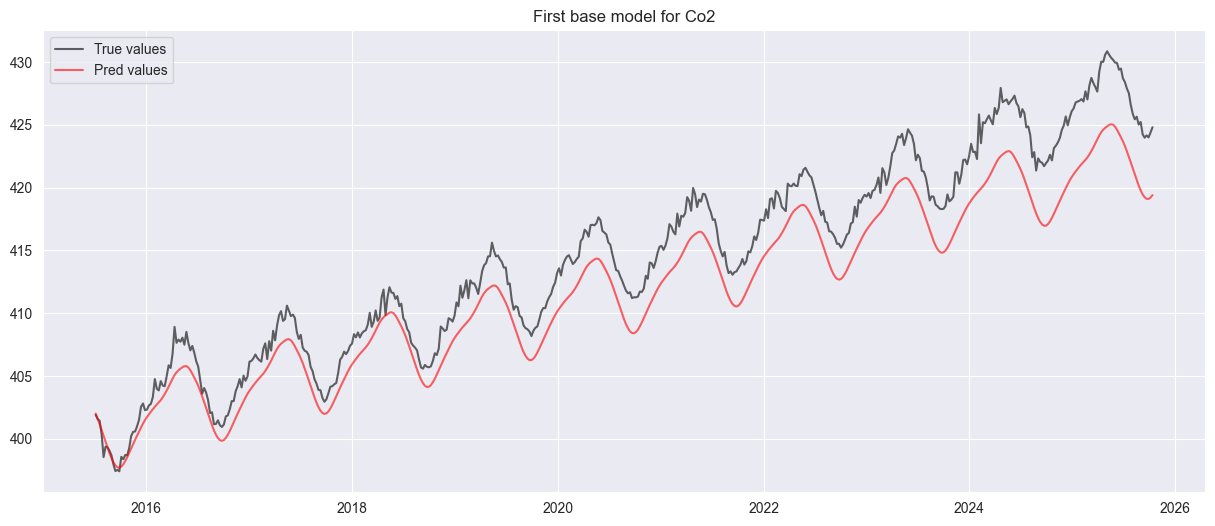

In [38]:
pred, df1 = build_model(train_co2, val_co2)
pred_plot(val_co2['ds'], val_co2['y'], pred, title="First base model for Co2")

17:41:17 - cmdstanpy - INFO - Chain [1] start processing
17:41:18 - cmdstanpy - INFO - Chain [1] done processing


 MAE = 2.67,
 RMSE = 2.98, MAPE = 0.64


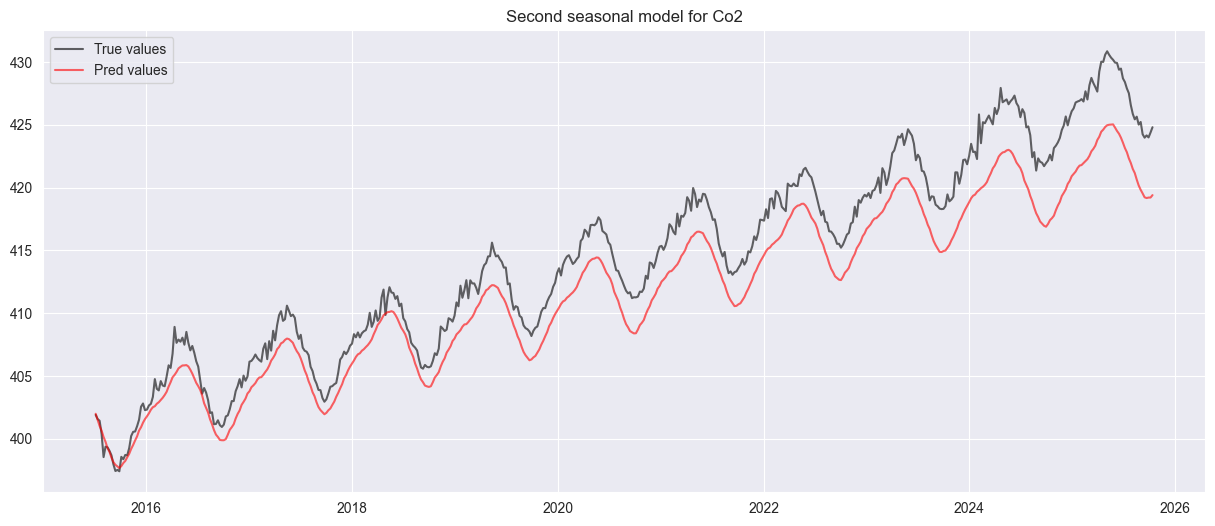

In [39]:
pred, df2 = build_model(train_co2, val_co2, season=True, s_name='weakly', p=104)
pred_plot(val_co2['ds'], val_co2['y'], pred, title="Second seasonal model for Co2")

In [40]:
metrics = pd.read_csv('../metrics/metrics_co2.csv', index_col='model')
metrics = pd.concat([metrics, df1, df2], axis=0)
metrics.to_csv("../metrics/metrics_co2.csv", index=True)
metrics

,rmse,mae,mape
model,,,
Seasonal mul 52,5.529192,4.908716,1.174563
Seasonal mul 104,5.158388,3.427763,1.008194
Seasonal add 52,5.390066,4.762221,1.139162
Seasonal add 104,4.240256,3.427763,0.817694
Seasonal 52,0.312890,0.243740,33.124523
Seasonal 104,0.026100,0.018483,71.833487
model_Prophet,2.973763,2.669463,0.639090
model_seasonal,2.975145,2.668529,0.638847


### Results:

Almost the same but first a little bit better.

| model     | MAE  | RMSE |
|-----------|------|------|
| Base      | 2.67 | 2.97 |
| Seasonal  | 2.67 | 2.98 |

17:41:18 - cmdstanpy - INFO - Chain [1] start processing
17:41:18 - cmdstanpy - INFO - Chain [1] done processing


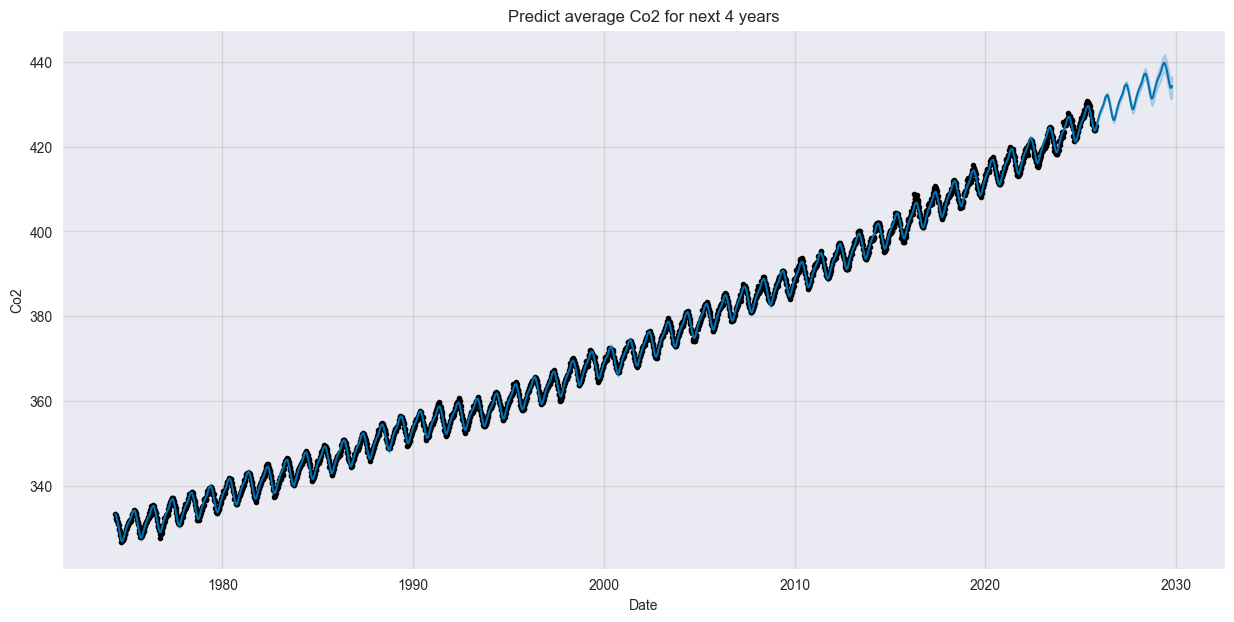

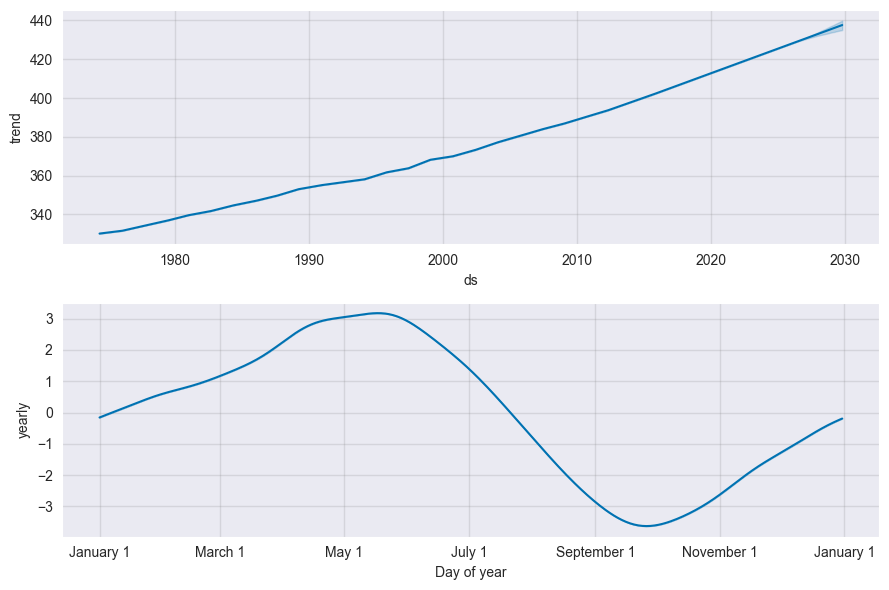

In [41]:
model, pred = build_model(train_co2, val_co2, calculate_metrics=False, pred_len=209, freq='W')
final_model(model, pred, 'Co2', title="Predict average Co2 for next 4 years")

In [42]:
model = Prophet()
model_flex = Prophet(changepoint_prior_scale=0.4)
model_flex.fit(train_co2)
future_test = val_co2[['ds']].copy()
forecast_test = model_flex.predict(future_test)

y_true = val_co2['y'].values
y_pred = forecast_test['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

df = pd.DataFrame({'model': ['changepoint prior'],
                           'rmse':  [rmse],
                           'mae':   [mae],
                           'mape':  [mape],
                          }).set_index('model')

17:41:19 - cmdstanpy - INFO - Chain [1] start processing
17:41:19 - cmdstanpy - INFO - Chain [1] done processing


In [43]:
metrics = pd.read_csv('../metrics/metrics_co2.csv', index_col='model')
metrics = pd.concat([metrics, df], axis=0)
metrics.to_csv("../metrics/metrics_co2.csv", index=True)
metrics

,rmse,mae,mape
model,,,
Seasonal mul 52,5.529192,4.908716,1.174563
Seasonal mul 104,5.158388,3.427763,1.008194
Seasonal add 52,5.390066,4.762221,1.139162
Seasonal add 104,4.240256,3.427763,0.817694
Seasonal 52,0.312890,0.243740,33.124523
Seasonal 104,0.026100,0.018483,71.833487
model_Prophet,2.973763,2.669463,0.639090
model_seasonal,2.975145,2.668529,0.638847
changepoint prior,2.953969,2.650524,0.634551


---
## Hourly AEP

In [44]:
aep = pd.read_csv('../data/hourly_aep.csv')
aep['data_ind'] = aep['Date']
aep = aep.set_index('data_ind')
aep.index = pd.to_datetime(aep.index)

train_df = aep.loc[aep.index < '2015-10-27 06:00:00']
val_df = aep.loc[aep.index >= '2015-10-27 06:00:00']

train = train_df[['AEP_MW']].reset_index()
train['unique_id'] = 'mw'
train.rename(columns={'data_ind': 'ds', 'AEP_MW': 'y'}, inplace=True)
train_aep = train[['unique_id', 'ds', 'y']]

val = val_df[['AEP_MW']].reset_index()
val['unique_id'] = 'mw'
val.rename(columns={'data_ind': 'ds', 'AEP_MW': 'y'}, inplace=True)
val_aep = val[['unique_id', 'ds', 'y']]

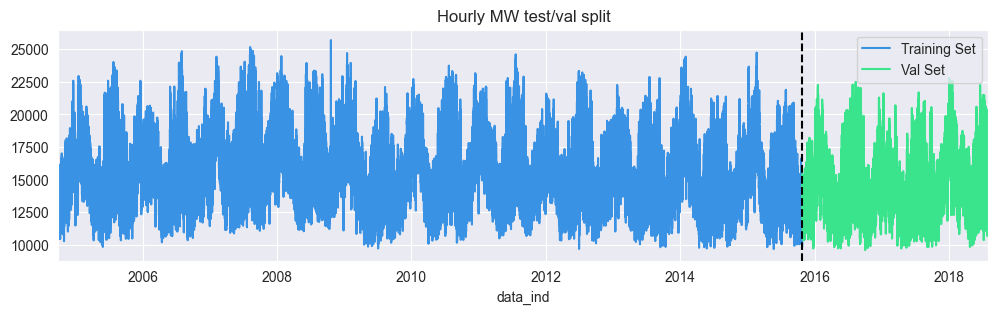

In [45]:
y_train = train_df['AEP_MW']
y_val = val_df['AEP_MW']

fig, ax = plt.subplots(figsize=(12, 3))
y_train.plot(ax=ax, label='Training Set', title='Hourly MW test/val split', color='#3A92E4')
y_val.plot(ax=ax, label='Val Set', color='#3AE48C')
ax.axvline('2015-10-27 06:00:00', color='black', ls='--')
ax.legend(['Training Set', 'Val Set'])
plt.show()

17:41:22 - cmdstanpy - INFO - Chain [1] start processing
17:41:43 - cmdstanpy - INFO - Chain [1] done processing


 MAE = 1409.45,
 RMSE = 1809.38, MAPE = 9.53


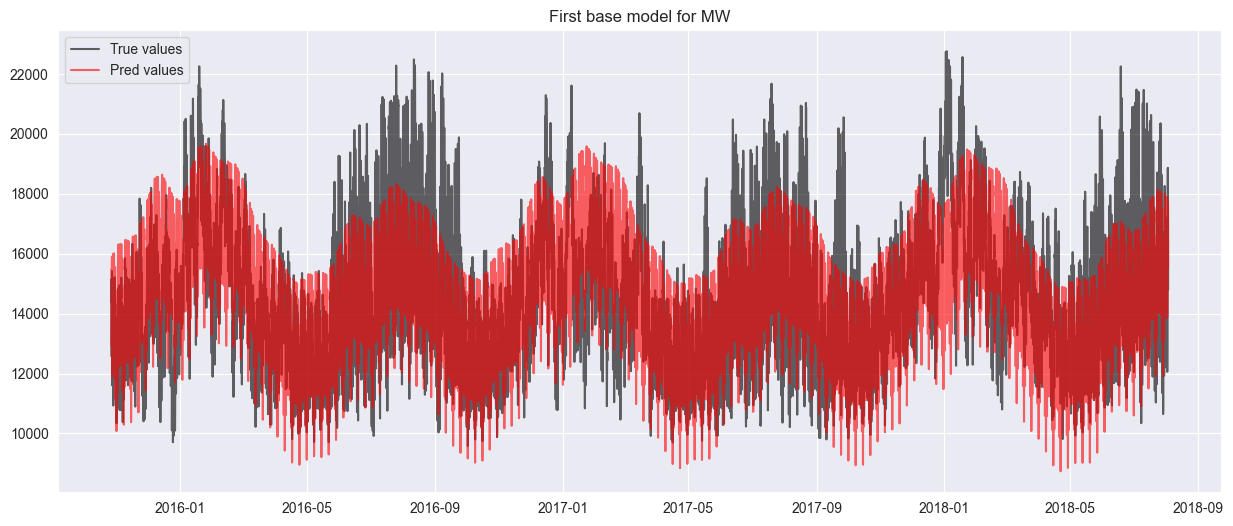

In [46]:
pred, df1 = build_model(train_aep, val_aep)
pred_plot(val_aep['ds'], val_aep['y'], pred, title="First base model for MW")

17:41:48 - cmdstanpy - INFO - Chain [1] start processing
17:42:18 - cmdstanpy - INFO - Chain [1] done processing


 MAE = 1398.01,
 RMSE = 1791.25, MAPE = 9.43


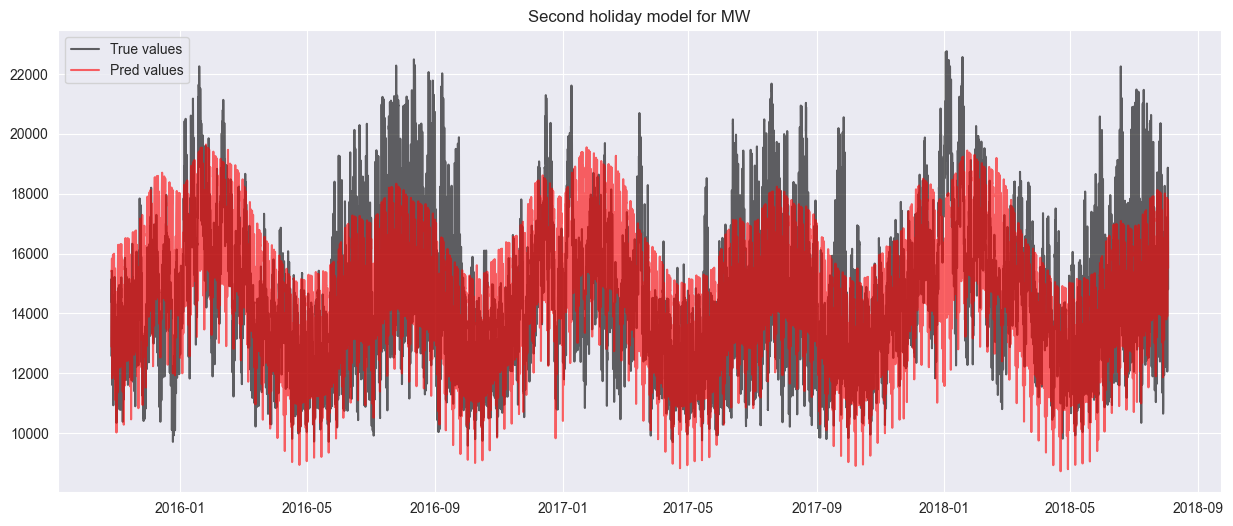

In [47]:
pred, df2 = build_model(train_aep, val_aep, holiday=True)
pred_plot(val_aep['ds'], val_aep['y'], pred, title="Second holiday model for MW")

17:42:26 - cmdstanpy - INFO - Chain [1] start processing
17:43:06 - cmdstanpy - INFO - Chain [1] done processing


 MAE = 1392.04,
 RMSE = 1785.20, MAPE = 9.39


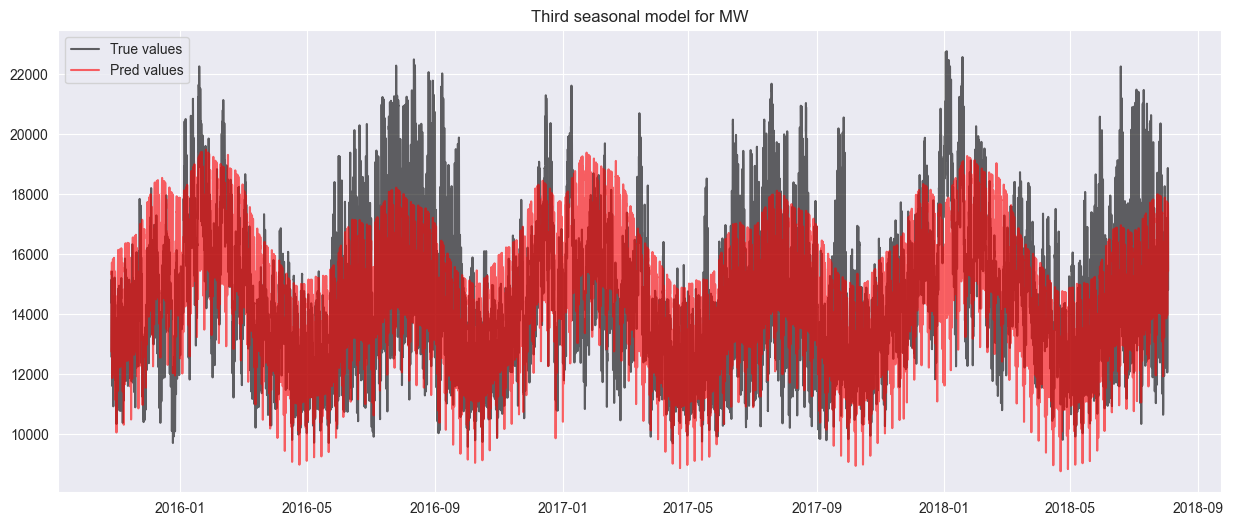

In [48]:
pred, df3 = build_model(train_aep, val_aep, holiday=True, season=True, s_name='hourly')
pred_plot(val_aep['ds'], val_aep['y'], pred, title="Third seasonal model for MW")

In [49]:
metrics = pd.read_csv('../metrics/metrics_aep.csv', index_col='model')
metrics = pd.concat([metrics, df1, df2, df3], axis=0)
metrics.to_csv("../metrics/metrics_aep.csv", index=True)
metrics

,rmse,mae,mape
model,,,
Seasonal add 4464,3147.157926,2487.105191,16.069787
Seasonal mul 4464,3104.978253,2414.155416,15.391711
Seasonal 12,316.352130,230.884742,414.907150
Seasonal 24,944.148515,658.421557,136.587328
Seasonal 744,33.767596,23.185635,115.722626
Seasonal 4464,377.378152,290.596682,73.467779
model_Prophet,1809.377231,1409.446186,9.526420
model_Prophet,1791.245937,1398.010247,9.433072
model_seasonal,1785.202620,1392.043594,9.390525


### Results:

First model is worth, second is worthier than third, so we will take third one.

| model    | MAE     | RMSE    |
|----------|---------|---------|
| Base     | 1409.45 | 1809.38 |
| Holiday  | 1398.01 | 1791.25 |
| Seasonal | 1392.04 | 1785.2  |


17:43:15 - cmdstanpy - INFO - Chain [1] start processing
17:43:54 - cmdstanpy - INFO - Chain [1] done processing


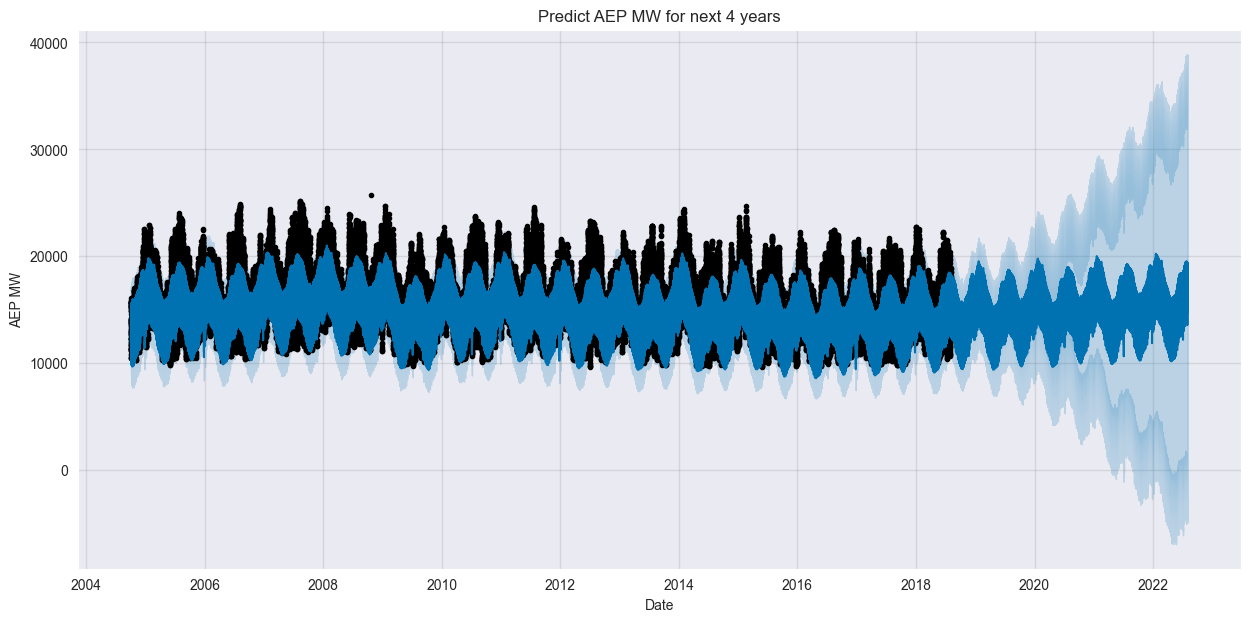

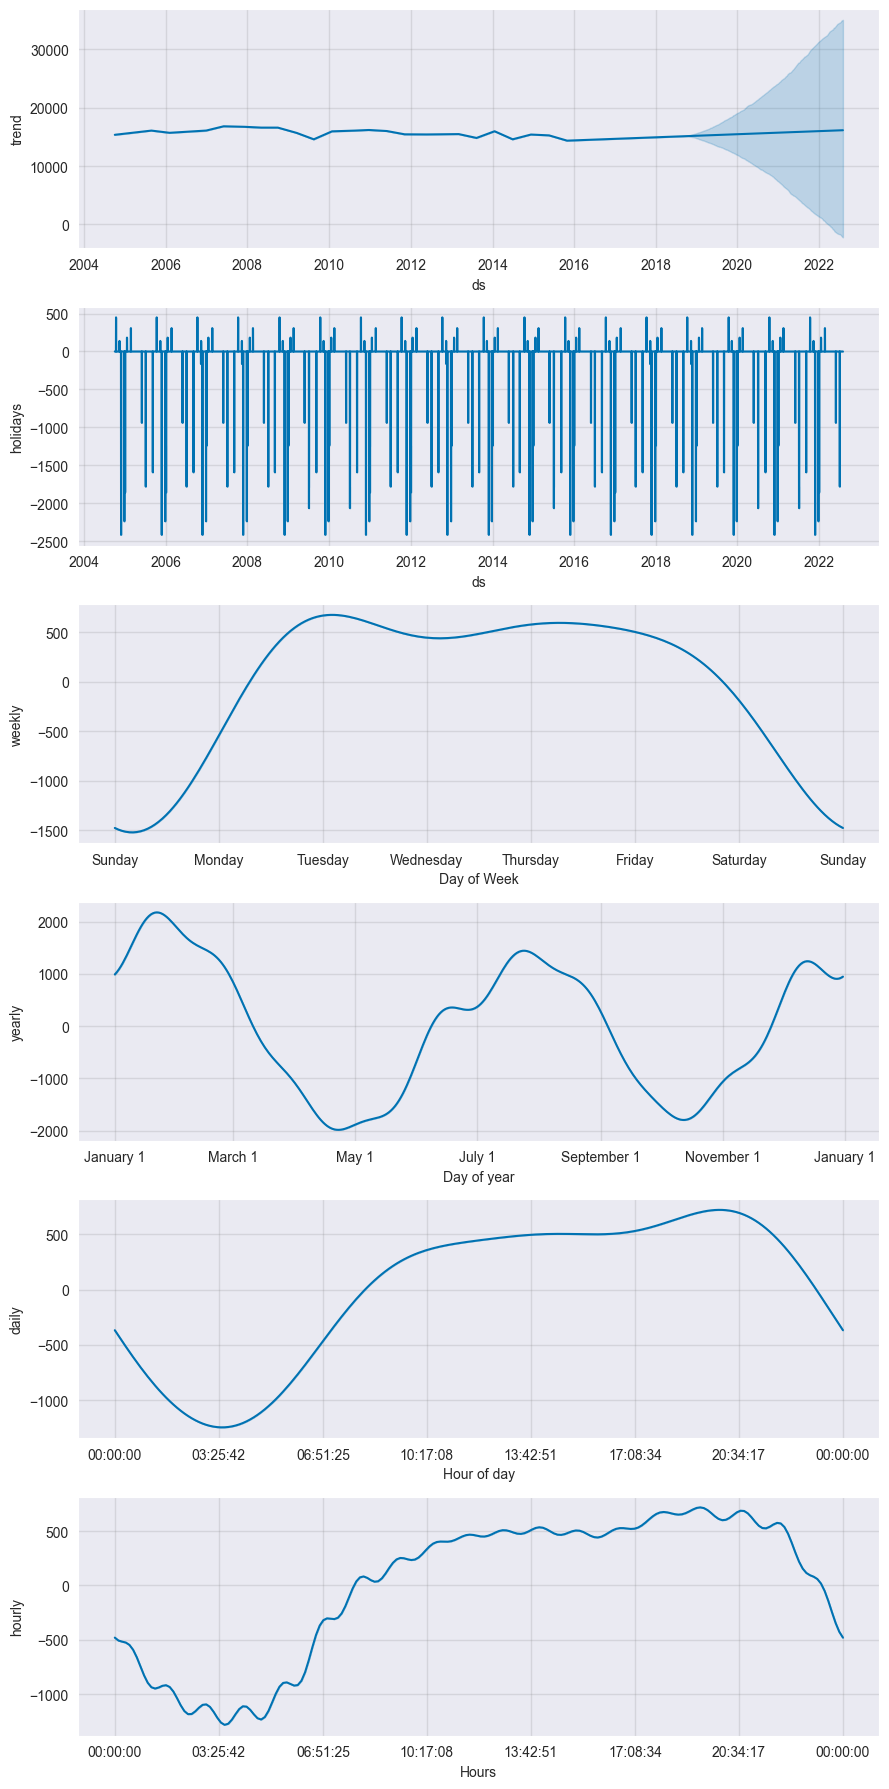

In [50]:
model, pred = build_model(train_aep, val_aep, holiday=True, season=True,
                          s_name='hourly', calculate_metrics=False, pred_len=35041, freq='h')
final_model(model, pred, 'AEP MW', title="Predict AEP MW for next 4 years")

---